# Importando

In [1]:
import matplotlib.pyplot as plt
import pandas as pd   
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

def ColabOuCode(path_drive, path_local, ncolunas=None):
    '''
    Importa o DataFrame de acordo com a plataforma usada. Retorna um DataFrame.
    '''
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        df = pd.read_csv(path_drive)
    except:
        if ncolunas is None: df = pd.read_csv(path_local)
        else: df = pd.read_csv(path_local, nrows=ncolunas)
    return df


In [2]:
drive = '/content/drive/MyDrive/Colab Notebooks/TERA-desafio-3/data/dados_tratados.csv'
local = './data/dados_tratados.csv'

df = ColabOuCode(
    drive,
    local,
    ncolunas=None
)

df.shape    

(2770409, 8)

In [3]:
df.head()

,oldbalanceOrig,origReinc,oldbalanceDest,destReinc,amount,type_CASH_OUT,type_TRANSFER,isFraud
0,5.198497,0,0.000000,0,5.198497,0,1,0
1,5.198497,0,9.960907,0,5.198497,1,0,0
2,9.637241,0,8.533657,0,12.342062,1,0,1
3,6.558198,0,10.017932,0,12.279836,0,1,1
4,9.290537,0,8.743053,0,12.649751,0,1,1


# Classificações

In [4]:
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

from imblearn.under_sampling import ClusterCentroids

from imblearn.combine import SMOTEENN

from sklearn.linear_model import LogisticRegression

In [5]:
from sklearn.model_selection import train_test_split

x_df = df.drop('isFraud',axis=1)
y_df = df[['isFraud']]

X_treino, X_teste, y_treino, y_teste = train_test_split(x_df, y_df, test_size=0.3, random_state=42)


## Regressão Logística

### Desbalanceados

In [6]:
y_teste.value_counts(normalize=True)

isFraud
1          0.996997
0          0.003003
dtype: float64

In [7]:
regLogistica = LogisticRegression(
    max_iter=100,
    class_weight='balanced',
)

regLogistica.fit(X_treino, y_treino)

y_regPredicao = regLogistica.predict(X_teste)

confusion_matrix(y_teste, y_regPredicao)

array([[  2334,    162],
       [127018, 701609]])

In [8]:
print(classification_report(y_teste, y_regPredicao, target_names=['Fraude', 'Nao Fraude']))


              precision    recall  f1-score   support

      Fraude       0.02      0.94      0.04      2496
  Nao Fraude       1.00      0.85      0.92    828627

    accuracy                           0.85    831123
   macro avg       0.51      0.89      0.48    831123
weighted avg       1.00      0.85      0.91    831123



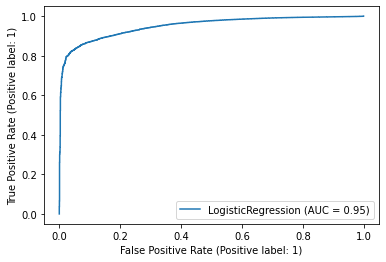

In [9]:
plot_roc_curve(regLogistica, X_teste, y_teste,)
plt.show()


### Balanceamento com OVER SAMPLE

#### ADASYN

In [10]:
overADASYN = ADASYN(
    random_state=42, 
    sampling_strategy=0.2
)
X_over, y_over = overADASYN.fit_resample(X_treino, y_treino)



In [11]:
print(y_treino.value_counts())
print()
print(y_over.value_counts())

isFraud
1          1933569
0             5717
dtype: int64

isFraud
1          1933569
0           386564
dtype: int64


In [12]:
regPredADASYN = LogisticRegression(
    max_iter=100,
    class_weight='balanced',
)

regPredADASYN.fit(X_over, y_over)

y_regPredADASYN = regPredADASYN.predict(X_teste)

confusion_matrix(y_teste, y_regPredADASYN)

array([[  2485,     11],
       [187339, 641288]])

In [13]:
print(classification_report(y_teste, y_regPredADASYN, target_names=['Fraude', 'Nao Fraude']))


              precision    recall  f1-score   support

      Fraude       0.01      1.00      0.03      2496
  Nao Fraude       1.00      0.77      0.87    828627

    accuracy                           0.77    831123
   macro avg       0.51      0.88      0.45    831123
weighted avg       1.00      0.77      0.87    831123



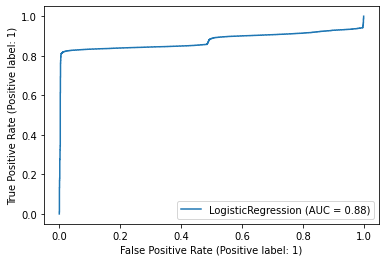

In [14]:
plot_roc_curve(regPredADASYN, X_teste, y_teste)
plt.show()

#### SMOTE

In [15]:
overSMOTE = SMOTE(
    random_state=42, 
    sampling_strategy=0.2
)
X_over, y_over = overSMOTE.fit_resample(X_treino, y_treino)


In [16]:
regPredSMOTE = LogisticRegression(
    max_iter=100,
    class_weight='balanced',
)

regPredSMOTE.fit(X_over, y_over)

y_regPredSMOTE = regPredSMOTE.predict(X_teste)

confusion_matrix(y_teste, y_regPredSMOTE)

array([[  2333,    163],
       [125055, 703572]])

In [17]:
print(classification_report(y_teste, y_regPredSMOTE, target_names=['Fraude', 'Nao Fraude']))


              precision    recall  f1-score   support

      Fraude       0.02      0.93      0.04      2496
  Nao Fraude       1.00      0.85      0.92    828627

    accuracy                           0.85    831123
   macro avg       0.51      0.89      0.48    831123
weighted avg       1.00      0.85      0.92    831123



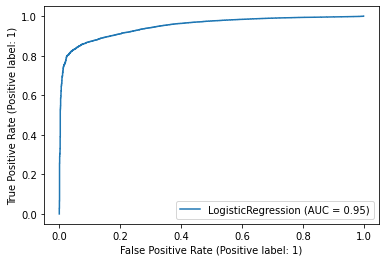

In [18]:
plot_roc_curve(regPredSMOTE, X_teste, y_teste)
plt.show()


### Balanceamento com UNDER SAMPLE

#### ClusterCentroids

In [19]:
'''
clusterC = ClusterCentroids(
    sampling_strategy=0.2,
    random_state=42
)

X_under, y_under = clusterC.fit_resample(X_treino, y_treino)
'''
pass

### (OVER+UNDER).SAMPLE

#### SMOTEENN

In [20]:
sennComb = SMOTEENN(
    sampling_strategy=0.5,
    random_state=42,
    n_jobs=-1
)

X_comb, y_comb = sennComb.fit_resample(X_treino, y_treino)


<AxesSubplot:xlabel='isFraud', ylabel='count'>

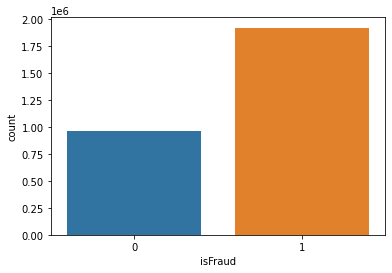

In [21]:
sns.countplot(y_comb['isFraud'])

In [22]:
redPrediSMNN = LogisticRegression(
    max_iter=100,
    class_weight='balanced',
)

redPrediSMNN.fit(X_comb, y_comb)

y_redPrediSMNN = redPrediSMNN.predict(X_teste)

confusion_matrix(y_teste, y_redPrediSMNN)

array([[  2336,    160],
       [123271, 705356]])

In [23]:
print(classification_report(y_teste, y_redPrediSMNN, target_names=['Fraude', 'Nao Fraude']))

              precision    recall  f1-score   support

      Fraude       0.02      0.94      0.04      2496
  Nao Fraude       1.00      0.85      0.92    828627

    accuracy                           0.85    831123
   macro avg       0.51      0.89      0.48    831123
weighted avg       1.00      0.85      0.92    831123



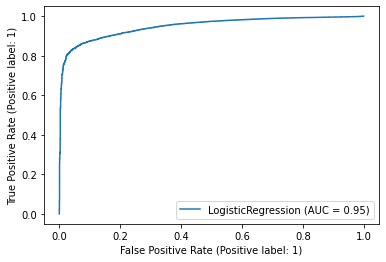

In [24]:
plot_roc_curve(redPrediSMNN, X_teste, y_teste)
plt.show()

### Tabela resumo das métricas da Regressão Logística

|Class	|Balanceamento	|class_weight	|sampling_strategy	|Acurácia	|Precision	|Recall	|F1 Score	|AUC|
|:-----:|:-------------:|:-------------:|:---------------------:|:-------------:|:-------------:|:-----:|:-------------:|:-:|
|RLog	|0		|None		|0.5			|1.00		|0.98		|0.58	|0.64		|0.94|
|RLog	|0		|balanced	|0.5			|0.85		|0.51		|0.89	|0.48		|0.95|
|RLog	|0		|manual	    	|0.5			|1.00		|1.00		|0.50	|0.50		|0.94|
|RLog	|ADASYN		|None		|0.5			|0.94		|0.50		|0.59	|0.50		|0.88|
|RLog	|ADASYN		|balanced	|0.5			|0.77		|0.51		|0.88	|0.50		|0.88|
|RLog	|SMOTE		|None		|0.5			|0.97   	|0.53		|0.82	|0.55		|0.95|	
|RLog	|SMOTE		|balanced	|0.5			|0.85		|0.51		|0.85	|0.85		|0.95|	
|RLog	|CC**		|None		|0.5			|0.00		|0.00		|0.00	|0.00		|0.00|
|RLog	|CC**		|balanced	|0.5			|0.00		|0.00		|0.00	|0.00		|0.00|
|RLog	|SMOTEENN   |None		|0.5			|0.91		|0.51		|0.86	|0.50		|0.95|
|RLog	|SMOTEENN 	|balanced	|0.5			|0.85		|0.51		|0.89	|0.48		|0.95|
|RLog	|SMOTEENN   |None		|0.1			|0.99 		|0.56		|0.78	|0.59		|0.95|
|RLog	|SMOTEENN 	|balanced	|0.1			|0.86		|0.51		|0.89	|0.48		|0.95|


** Não rodou